# October 25-26, 2022: MAX dataset network analysis

In [1]:
import bct
import csv
import os
import pickle
import random
import sys
from copy import deepcopy
from itertools import combinations
from os.path import join as pjoin

import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
from brainiak.isc import compute_correlation, squareform_isfc
from scipy import signal
from tqdm.notebook import tqdm
from scipy.spatial.distance import squareform

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/oct22"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils_v1 as dataset_utils
import helpers.isc_utils as isc_utils
import helpers.fc_utils as fc_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 74
np.random.seed(args.SEED)

args.LABEL_NAMES = ['FNT', 'FNS']
args.NAMES = ['Threat', 'Safe']
args.TRIAL_LEN = 14
args.TR = 1.25 #seconds
EARLY = np.arange(2.5, 8.75+args.TR, args.TR) // args.TR
LATE = np.arange(10.0, 16.25+args.TR, args.TR) // args.TR
EARLY = EARLY.astype(int)
LATE = LATE.astype(int)
args.PERIOD_TRS = {'late': LATE, 'early': EARLY}

In [3]:
args.proj_dir = proj_dir
args.roi_set_name = 'mashid'
args.main_data_dir = (
    f"{proj_dir}/data/max/neutral_runs_trial_level_FNSandFNT/{args.roi_set_name}"
)
# exploratory data
args.subjects = os.listdir(args.main_data_dir)
random.Random(args.SEED).shuffle(args.subjects)
args.explor_subjects = args.subjects[ : round(0.25 * len(args.subjects))]

# ROIs
args = dataset_utils.get_mashid_rois(args)
args = dataset_utils.get_mashid_plot_tick_labels(args)

[13 12 12  8]
[13 25 37]
[ 7 19 31 41]
['Salience' 'Executive' 'Task negative' 'Subcortical']


## dataset

  0%|          | 0/27 [00:00<?, ?it/s]

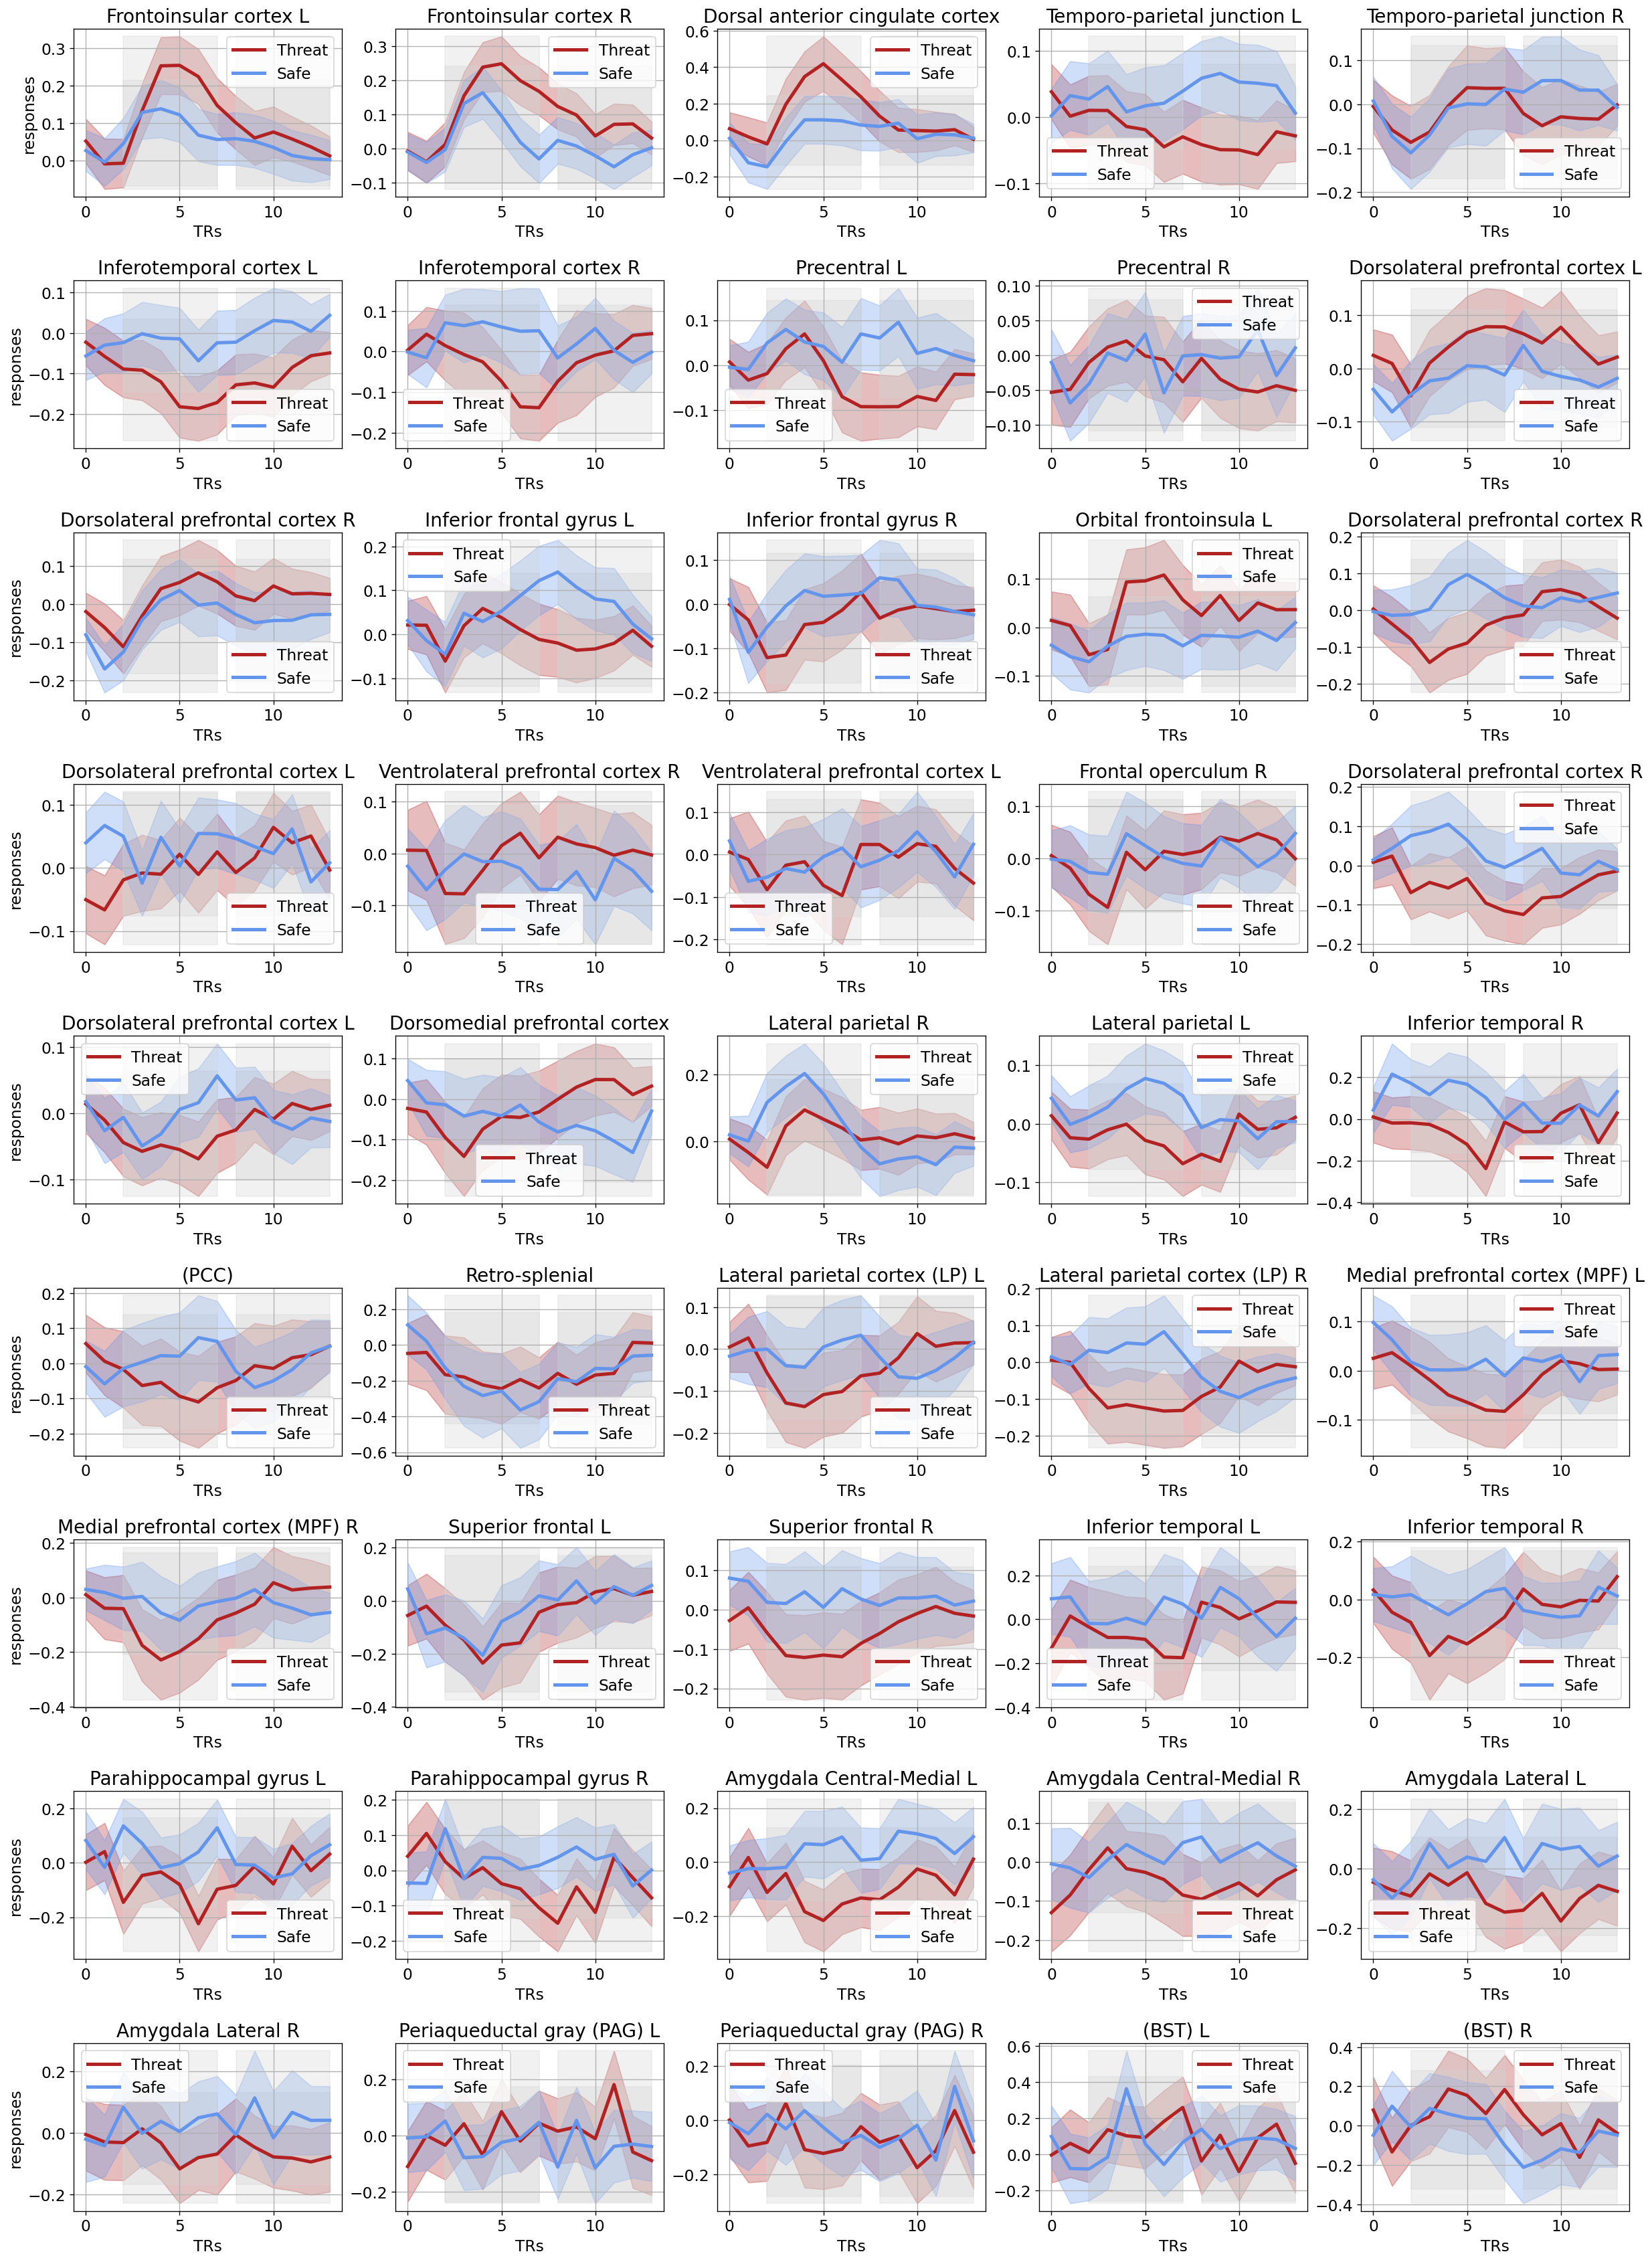

In [4]:
X = dataset_utils.get_max_trial_level_responses(args)
for name in X.keys():
    X[name] = [x for x in X[name] if x.shape[-1] == args.num_rois if x.shape[0] > 11]
    for idx_subj in range(len(X[name])):
        X[name][idx_subj] = X[name][idx_subj][:, :, args.roi_idxs]

args.plot_colors = {'Threat': 'firebrick', 'Safe': 'cornflowerblue'}
dataset_utils.plot_max_responses(args, X)

In [5]:
# subject-wise responses at each TR
ts = dataset_utils.get_max_block_time_series(args, X,)
args.blocks = list(ts.keys())

## ISC

100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


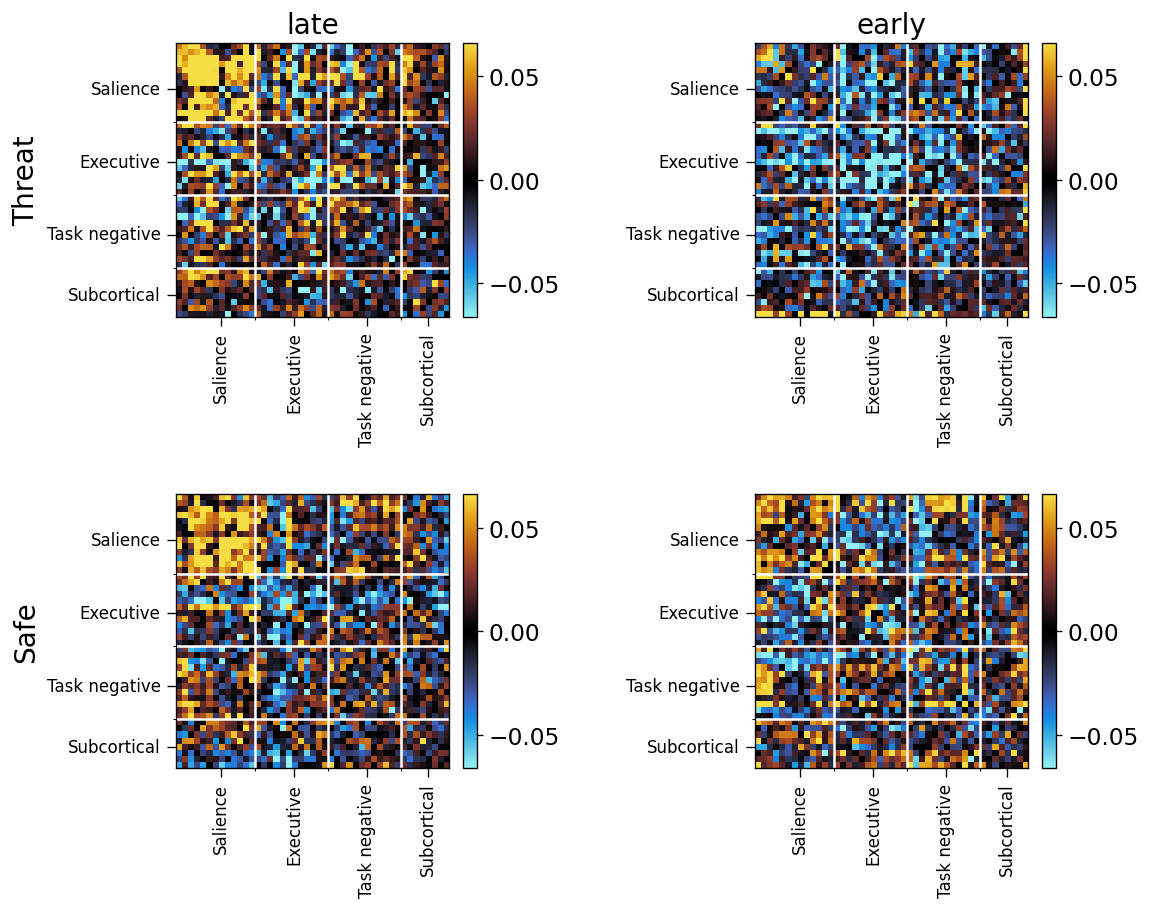

In [6]:
# ISC matrices for both periods (early/late) and 
# both emotional conditions (threat/safe)
args.CORR_NAMES = ['isfcs', 'iscs']
args.pairwise=False
args.vectorize_isfcs = True
args.n_bootstraps = 1000
args.positive_only = False
(
    corrs, 
    bootstraps, 
    rois
) = isc_utils.get_isfcs(
    args, 
    ts
)
(
    observed_isfcs, observed_p_vals, 
    significant_rois, conf_intervals
) = isc_utils.get_squareform_matrices(
    args, 
    bootstraps, 
    rois,
    threshold_mats=False
)
isc_utils.plot_max_isfcs(
    args, 
    observed_isfcs, 
    significant_rois
)

6it [00:14,  2.37s/it]


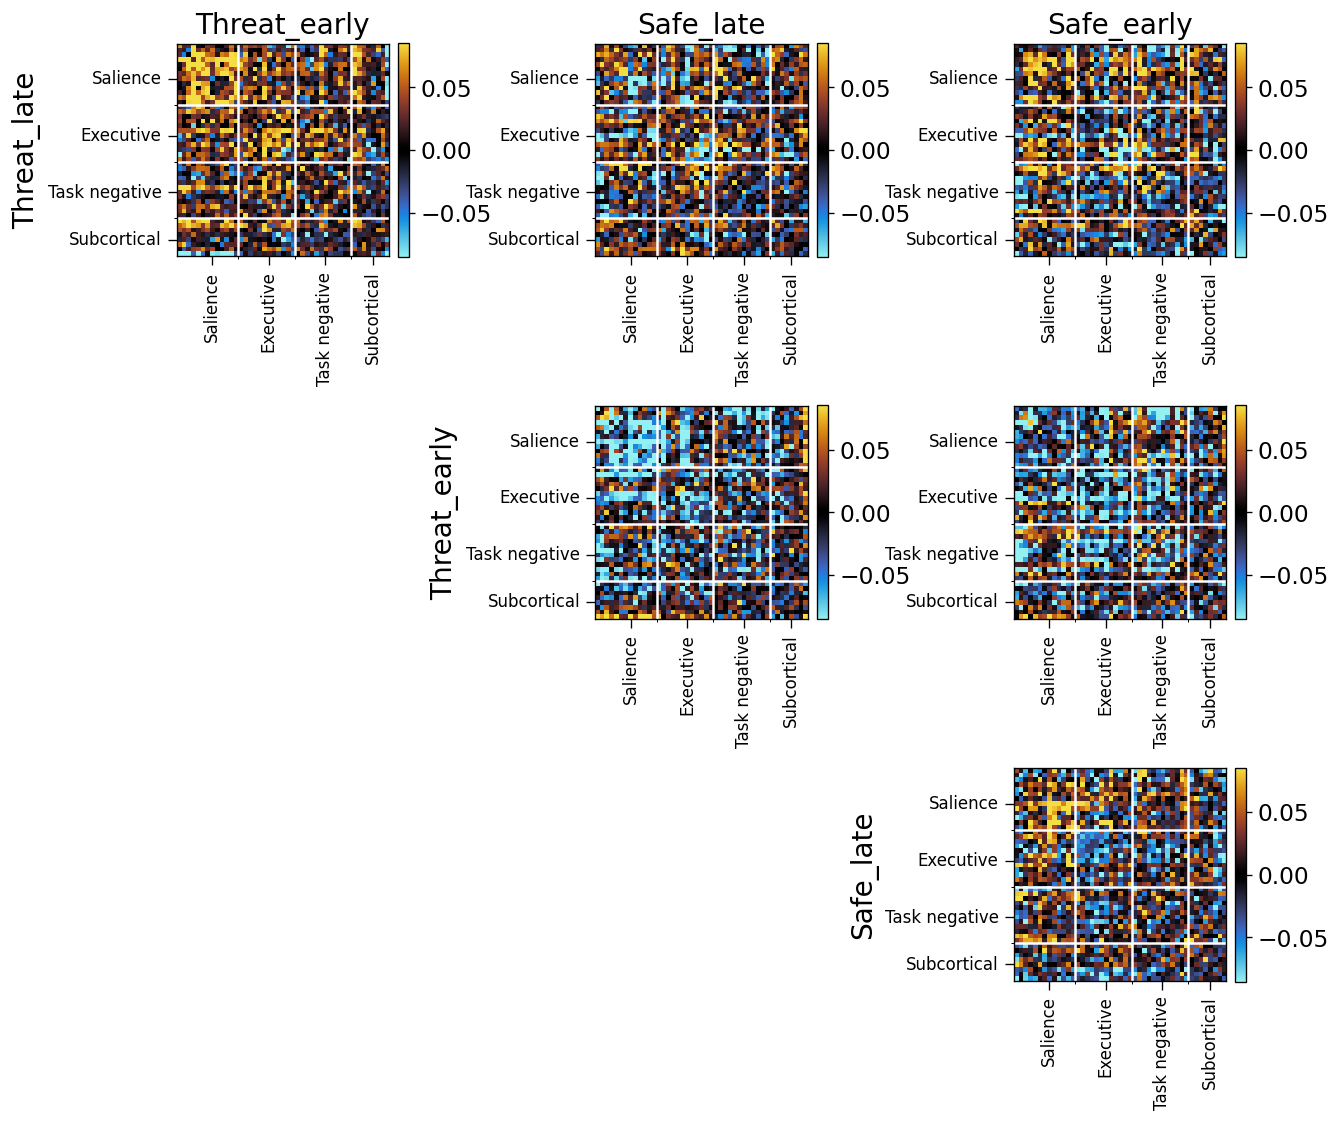

In [7]:
# difference ISCs
stats_results = isc_utils.get_comparison_stats(
    args, 
    corrs,
    paradigm='max',
    how_pairs='all_combs',
)
(
    diff_isfcs, 
    diff_pvals
) = isc_utils.get_diff_isfcs(
    args, 
    stats_results, 
    significant_rois, 
    threshold_mats=False
)
isc_utils.plot_isfc_comparisons(
    args, 
    corrs, 
    diff_isfcs, 
    paradigm='max'
)

In [8]:
# bootstrap ISCs
(
    bootstrap_isfcs, 
    all_isfcs
) = isc_utils.get_bootstrap_distribution_isfcs(
    args, 
    observed_isfcs, 
    bootstraps,
)

In [9]:
# separate positive and negative weights
(
    all_isfcs_pos, all_isfcs_neg,
    all_sq_isfcs_pos, all_sq_isfcs_neg
) = isc_utils.separate_pos_neg_weights(
    args, 
    all_isfcs, 
    significant_rois
)

## Analysis

In [10]:
args.plot_blocks = ['Tl', 'Te', 'Sl', 'Se']

### network-weight plots

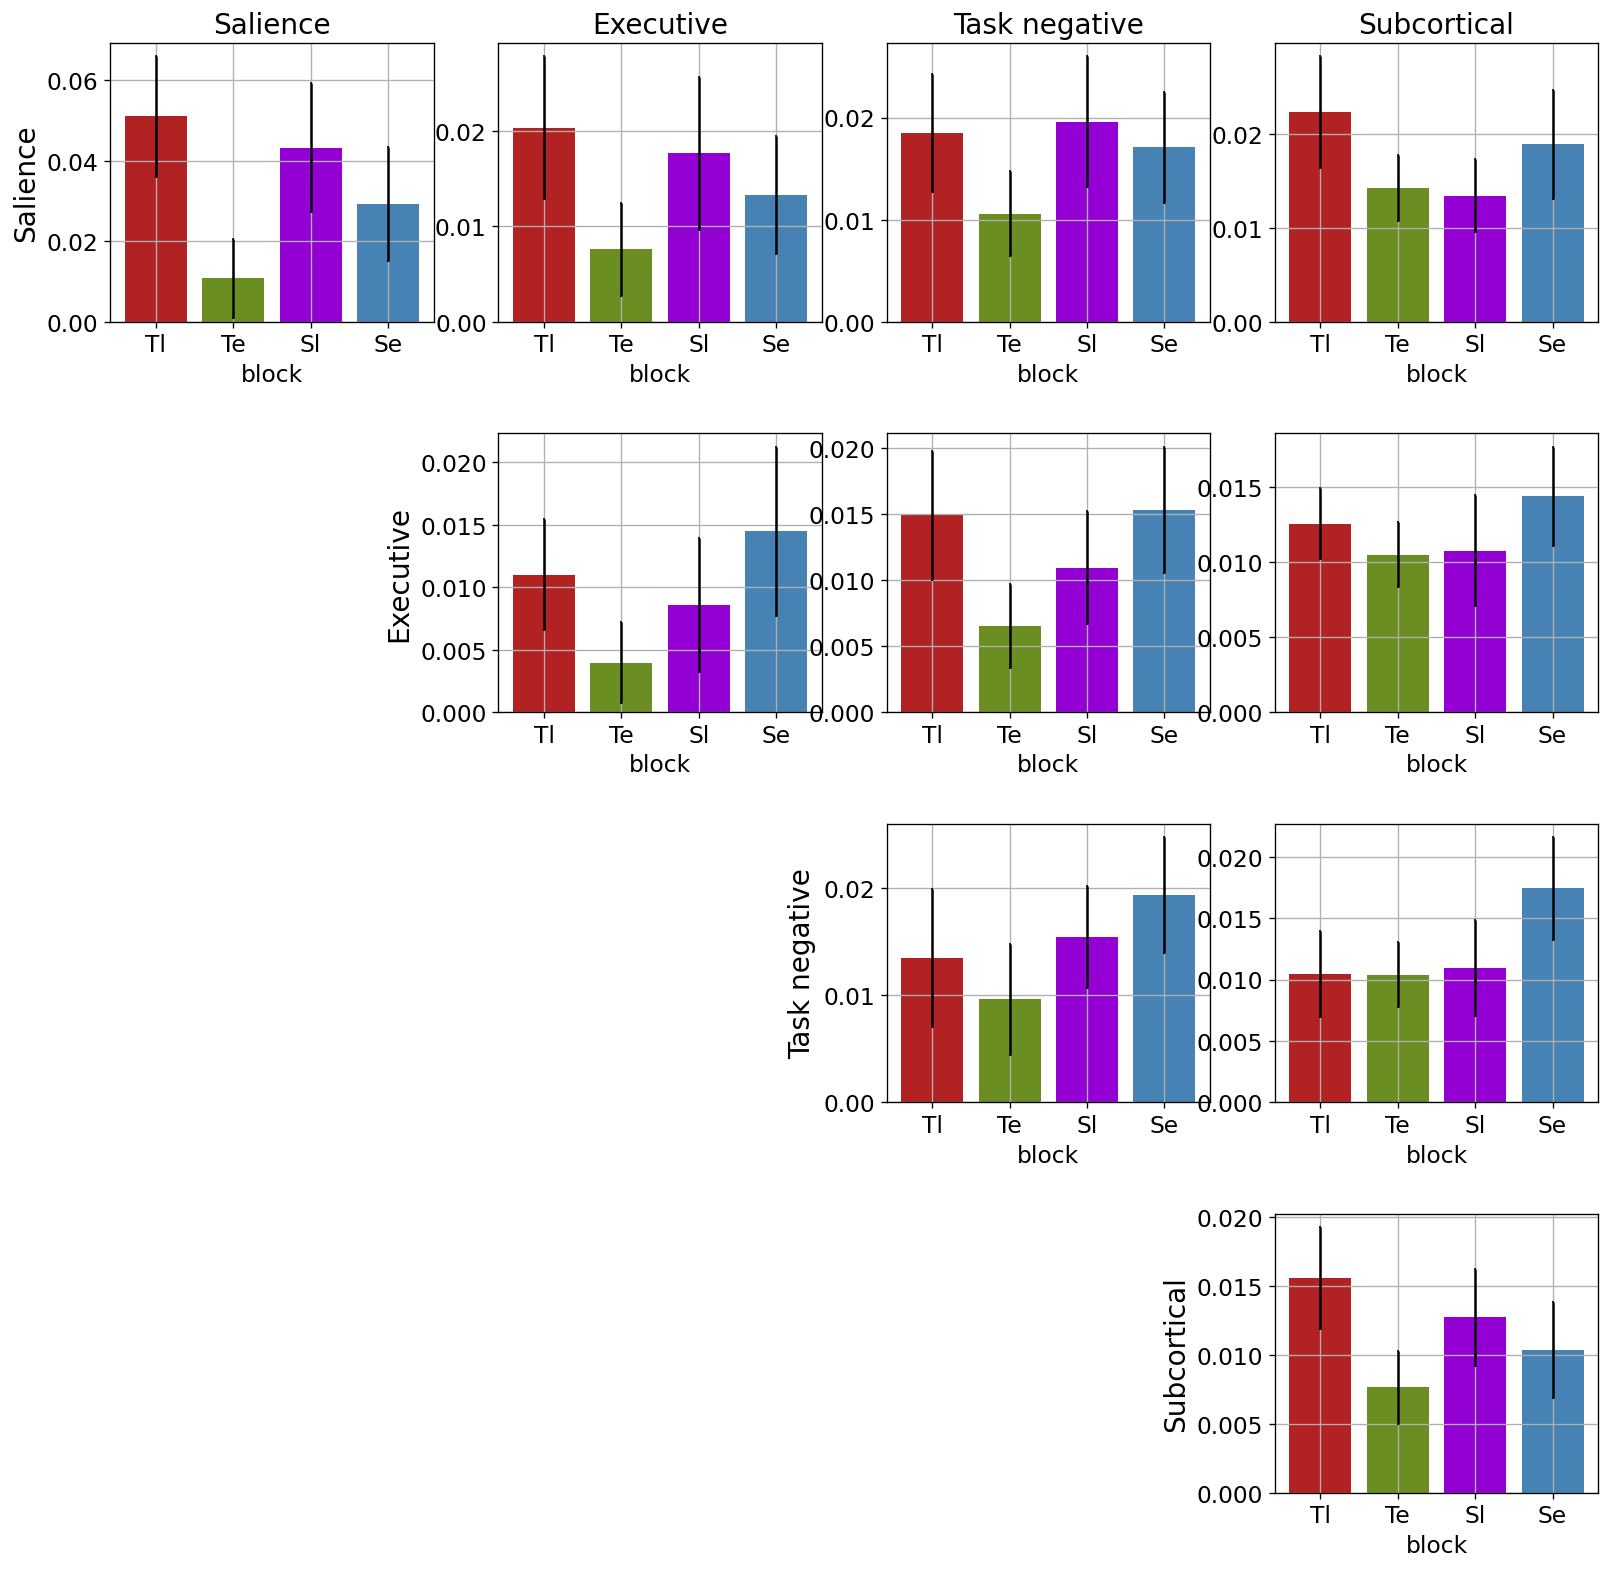

In [11]:
# within- and between-network positive weights
nw_weights_pos = isc_utils.get_nw_weights(
    args, 
    all_sq_isfcs_pos
)

args.plot_colors = {
    'Threat_late':'firebrick', 'Threat_early':'olivedrab', 
    'Safe_late':'darkviolet',   'Safe_early':'steelblue'
}
isc_utils.plot_max_nw_weights(args, nw_weights_pos)

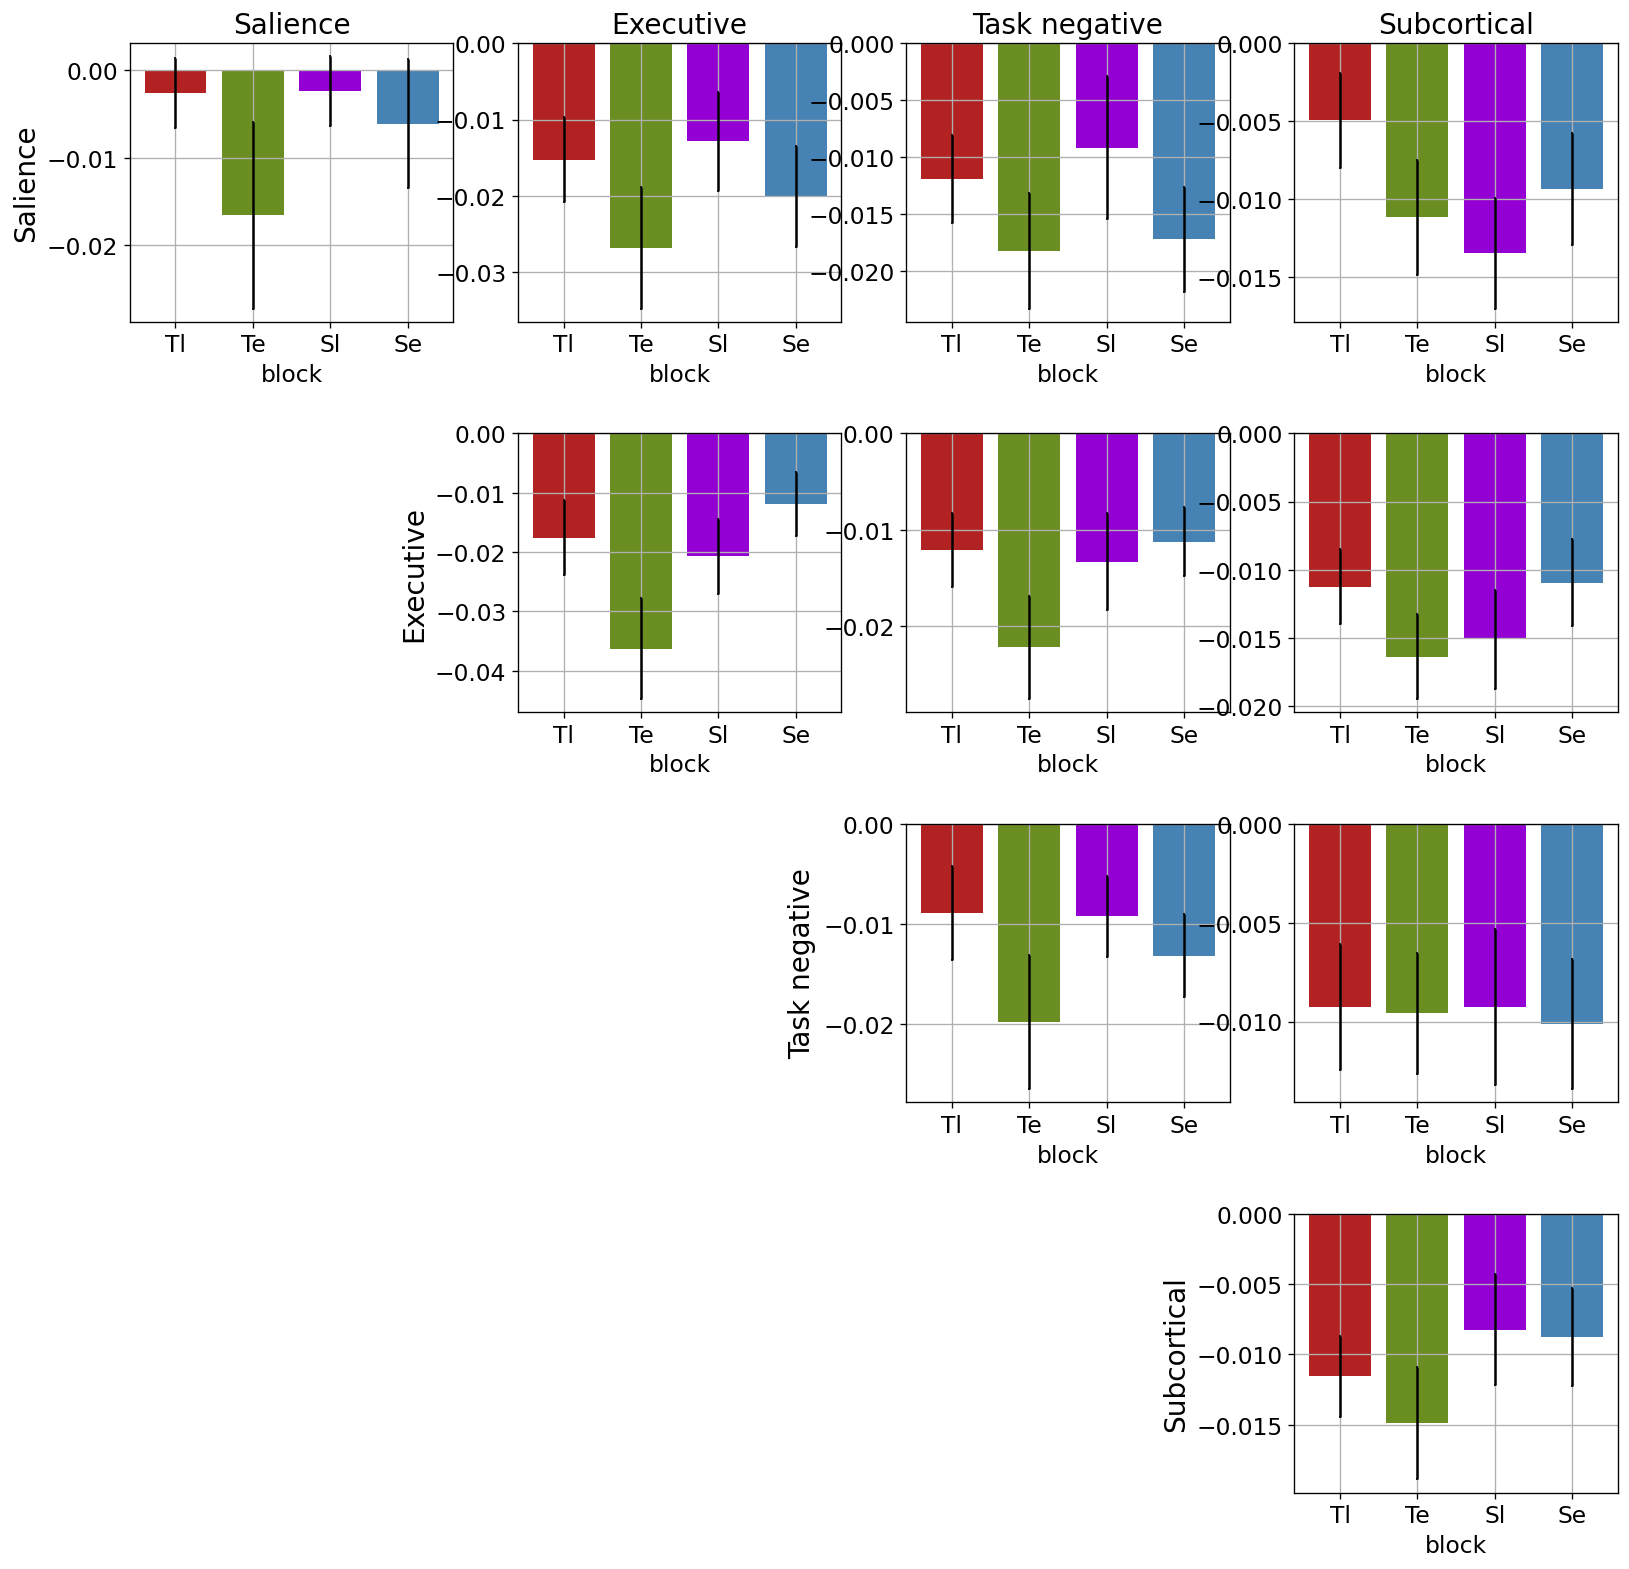

In [12]:
# within- and between-network negative weights
nw_weights_neg = isc_utils.get_nw_weights(
    args, 
    all_sq_isfcs_neg
)

args.plot_colors = {
    'Threat_late':'firebrick', 'Threat_early':'olivedrab', 
    'Safe_late':'darkviolet',   'Safe_early':'steelblue'
}
isc_utils.plot_max_nw_weights(args, -1 * nw_weights_neg)

### basic network measures
<!-- 1. **integration**: efficiency -->
<!-- 2. **segregation**: modularity
3. **centrality**: betweenness -->

In [13]:
def compute_network_measures(args, all_sq_isfcs):
    nw_measures = {}

    # efficiency
    nw_measures['global_efficiency'] = np.array([
        bct.distance.efficiency_wei(all_sq_isfcs[block][:, :, 0], local=False)
        for block in all_sq_isfcs.keys()
    ])

    nw_eff = np.zeros(shape=(len(args.blocks), len(args.nw_roi_idxs.keys())))
    for idx_block, block in enumerate(all_sq_isfcs.keys()):

        e = bct.distance.efficiency_wei(all_sq_isfcs[block][:, :, 0], local=True)

        for idx_nw, nw in enumerate(args.nw_roi_idxs.keys()):
            nw_eff[idx_block, idx_nw] = np.mean(e[args.nw_roi_idxs[nw]])

    nw_measures['local_efficiency'] = nw_eff

    # betweenness centrality
    nw_btwness = np.zeros(shape=(len(args.blocks), len(args.nw_roi_idxs.keys())))
    for idx_block, block in enumerate(all_sq_isfcs.keys()):
        
        b = bct.centrality.betweenness_wei(all_sq_isfcs[block][:, :, 0])
        
        for idx_nw, nw in enumerate(args.nw_roi_idxs.keys()):
            
            nw_btwness[idx_block, idx_nw] = np.mean([b[args.nw_roi_idxs[nw]]])

    nw_measures['betweenness'] = nw_btwness

    # modularity
    nw_measures['modularity'] = np.array([
        bct.modularity.modularity_und(
            all_sq_isfcs[block][:, :, 0],
            kci=args.roi_nw_to_idx
        )[1]
        for block in all_sq_isfcs.keys()
    ])

    return nw_measures

def plot_max_global_efficiency(args, nw_measures):
    fig, axs = plt.subplots(
        nrows=1, 
        ncols=1,
        figsize=(5, 4),
        dpi=120
    )
    ax = axs
    x = np.arange(len(args.blocks))
    y = nw_measures['global_efficiency']
    ax.bar(
        x,
        y,
        align='center',
        color=args.plot_colors['global_efficiency'],
        linewidth=3,
        # yerr=0
    )
    ax.set_title(f"{args.title}")
    ax.set_xlabel(f"block")
    ax.set_ylabel(f"global_efficiency")
    # ax.legend()
    ax.set_xticks(x)
    ax.set_xticklabels(args.plot_blocks)
    ax.grid(True)

def plot_max_local_efficiency(args, nw_measures):
    nrows, ncols = 1, 1
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=(10*ncols, 4*nrows),
        dpi=120
    )

    ax = axs
    measure = nw_measures['local_efficiency']
    v = max(abs(np.min(measure)), abs(np.max(measure)))
    vmin, vmax = -v, v
    im = ax.imshow(
        measure,
        cmap=cmr.iceburn, vmin=vmin, vmax=vmax,
    )
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(f"local_efficiency {args.title}")
    ax.set_xlabel(f"block")
    ax.set_ylabel(f"network")
    # ax.legend()
    ax.set_xticks(range(len(args.plot_blocks)))
    ax.set_xticklabels(args.plot_blocks)
    ax.set_yticks(range(len(args.nw_roi_idxs.keys())))
    ax.set_yticklabels(args.nw_roi_idxs.keys())
    ax.grid(True)

def plot_max_betweenness(args, nw_measures):
    nrows, ncols = 1, 1
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=(10*ncols, 4*nrows),
        dpi=120
    )

    ax = axs
    measure = nw_measures['betweenness']
    v = max(abs(np.min(measure)), abs(np.max(measure)))
    vmin, vmax = -v, v
    im = ax.imshow(
        measure,
        cmap=cmr.iceburn, vmin=vmin, vmax=vmax,
    )
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(f"betweenness {args.title}")
    ax.set_xlabel(f"block")
    ax.set_ylabel(f"network")
    # ax.legend()
    ax.set_xticks(range(len(args.plot_blocks)))
    ax.set_xticklabels(args.plot_blocks)
    ax.set_yticks(range(len(args.nw_roi_idxs.keys())))
    ax.set_yticklabels(args.nw_roi_idxs.keys())
    ax.grid(True)

def plot_max_modularity(args, nw_measures):
    fig, axs = plt.subplots(
        nrows=1, 
        ncols=1,
        figsize=(5, 4),
        dpi=120
    )
    ax = axs
    x = np.arange(len(args.blocks))
    y = nw_measures['modularity']
    ax.bar(
        x,
        y,
        align='center',
        color=args.plot_colors['modularity'],
        linewidth=3,
        # yerr=0
    )
    ax.set_title(f"{args.title}")
    ax.set_xlabel(f"block")
    ax.set_ylabel(f"modularity")
    # ax.legend()
    ax.set_xticks(x)
    ax.set_xticklabels(args.plot_blocks)
    ax.grid(True)

nw_measures_pos = compute_network_measures(args, all_sq_isfcs_pos.copy())
nw_measures_neg = compute_network_measures(args, all_sq_isfcs_neg.copy())

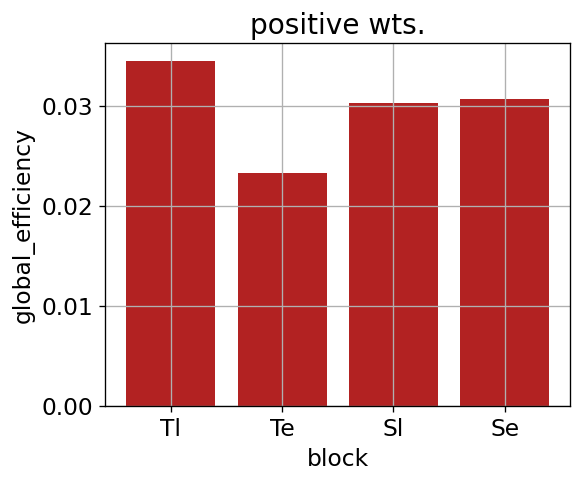

In [14]:
args.plot_colors = {'global_efficiency':'firebrick'}
args.title = f"positive wts."
plot_max_global_efficiency(args, nw_measures_pos)

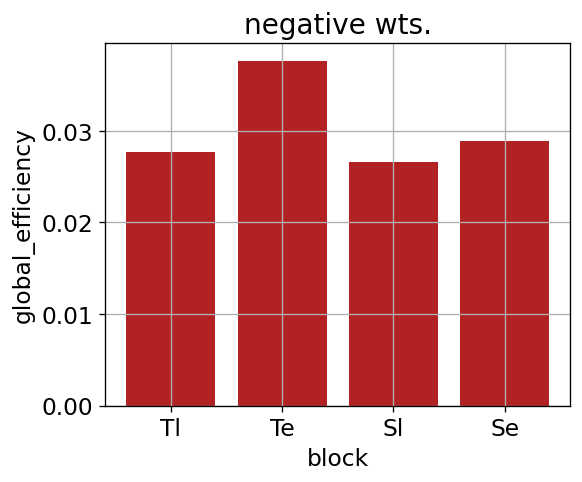

In [15]:
args.plot_colors = {'global_efficiency':'firebrick'}
args.title = f"negative wts."
plot_max_global_efficiency(args, nw_measures_neg)

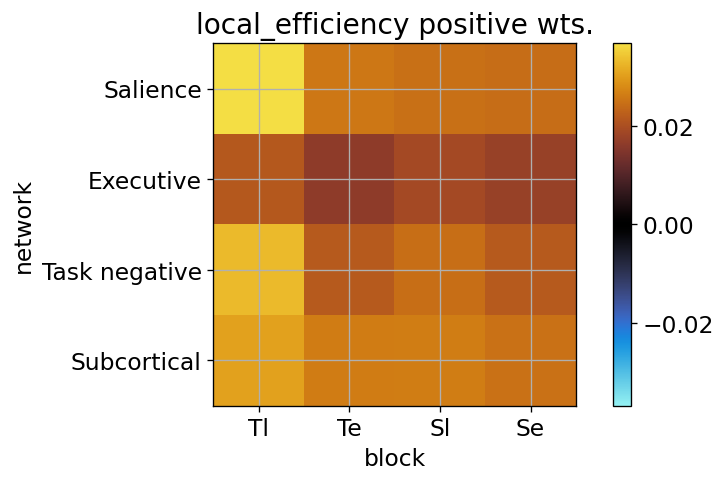

In [16]:
args.title = f"positive wts."
plot_max_local_efficiency(args, nw_measures_pos)

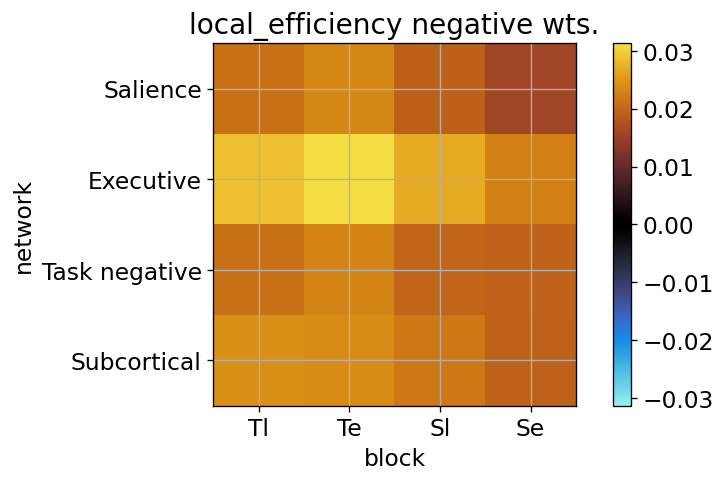

In [17]:
args.title = f"negative wts."
plot_max_local_efficiency(args, nw_measures_neg)

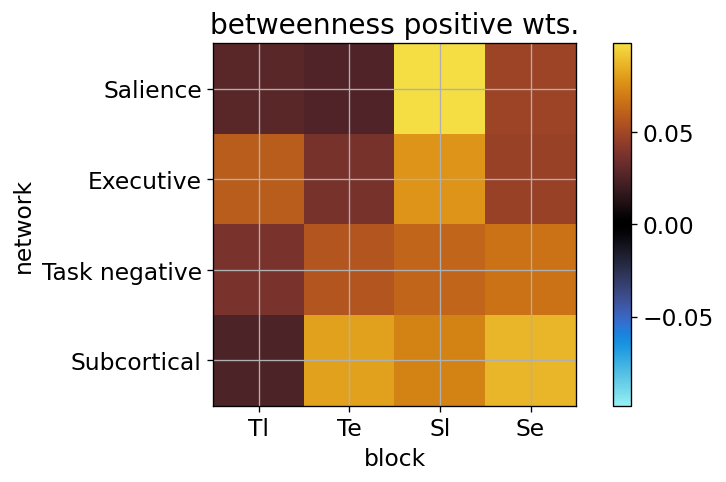

In [18]:
args.title = f"positive wts."
plot_max_betweenness(args, nw_measures_pos)

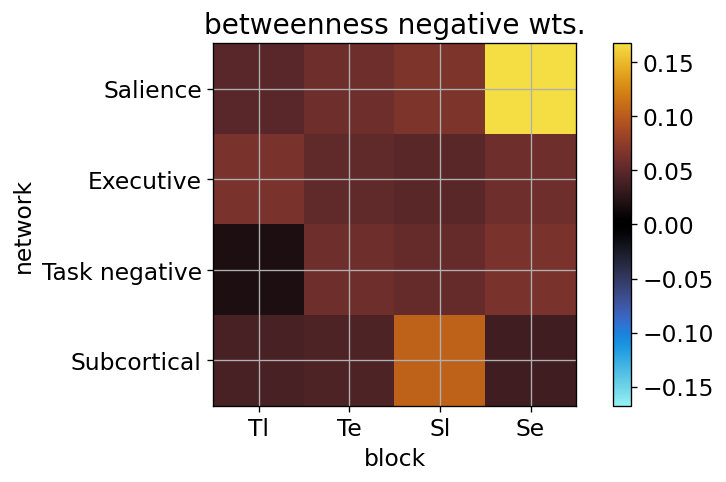

In [19]:
args.title = f"negative wts."
plot_max_betweenness(args, nw_measures_neg)

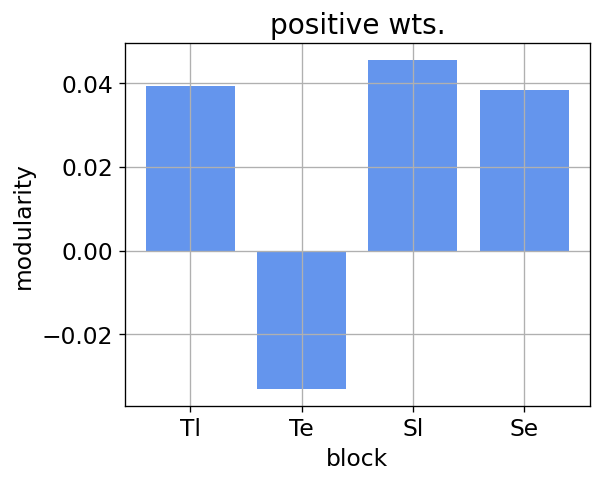

In [20]:
args.plot_colors = {
    'modularity': 'cornflowerblue'
}
args.title = f"positive wts."
plot_max_modularity(args, nw_measures_pos)

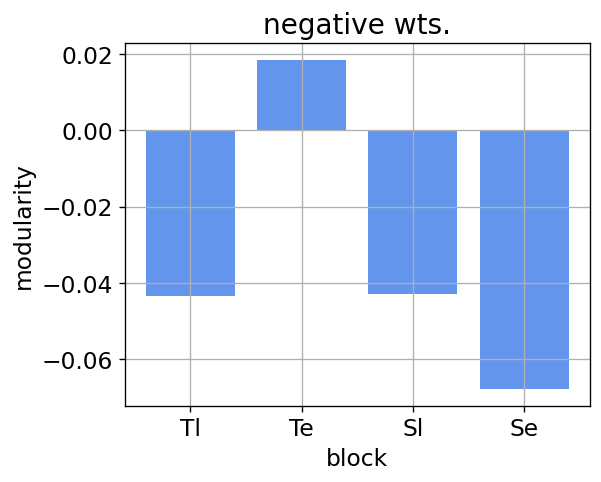

In [21]:
args.plot_colors = {
    'modularity': 'cornflowerblue'
}
args.title = f"negative wts."
plot_max_modularity(args, nw_measures_neg)

1. confidence intervals around each plot

## FC

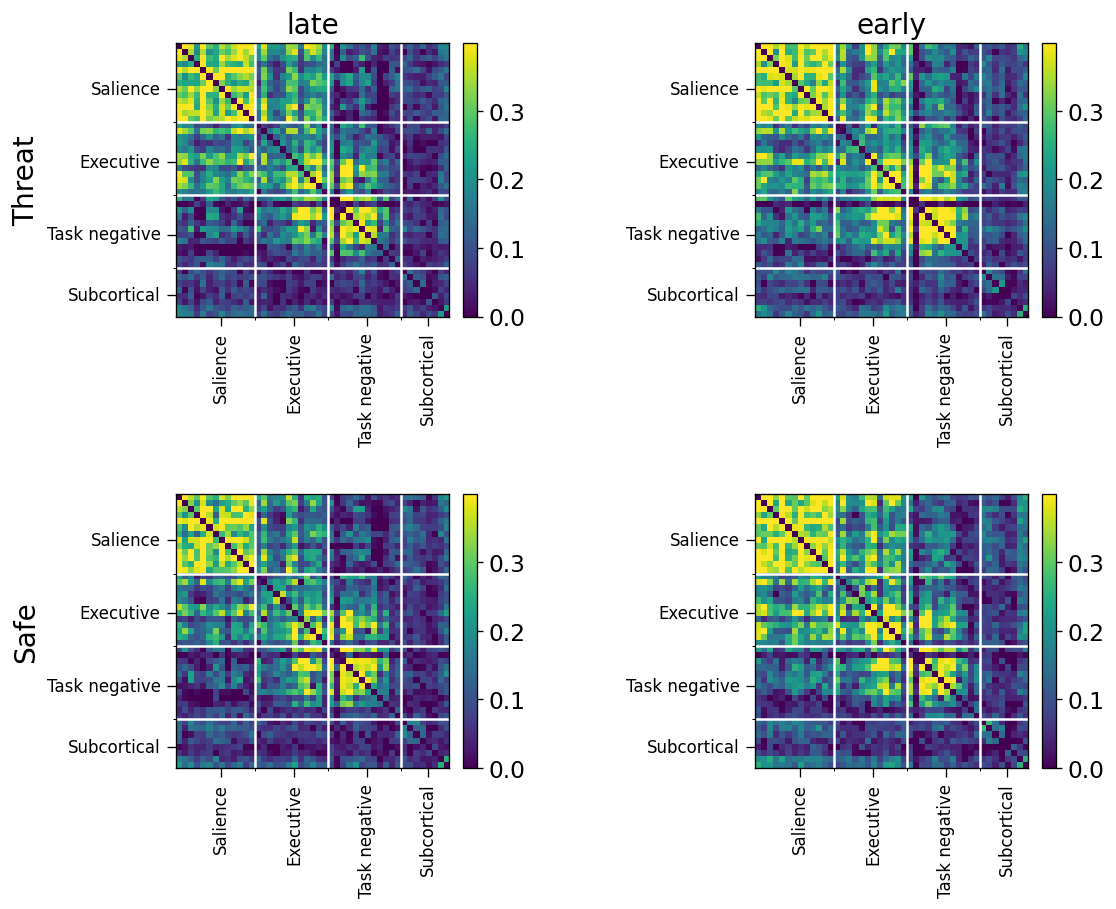

In [22]:
ts_fc = ts.copy()
for block in ts_fc.keys():
    ts_fc[block] = np.moveaxis(ts_fc[block], -1, 0)

args.n_bootstraps = 1000
(
    corrs, 
    bootstraps, 
    rois
) = fc_utils.get_fcs(
    args, 
    ts_fc, 
    print_stats=False
)

(
    observed_fcs, observed_p_vals, 
    significant_rois, conf_intervals
) = fc_utils.get_squareform_matrices(
    args, 
    bootstraps, 
    rois,
    threshold_mats=False
)

isc_utils.plot_max_isfcs(
    args, 
    observed_fcs, 
    significant_rois,
    cmap=mpl.colormaps['viridis'],
    corr_type='fc'
)

In [23]:
# bootstrap FCs
(
    bootstrap_fcs, 
    all_fcs
)  = fc_utils.get_bootstrap_distribution_fcs(
    args, 
    observed_fcs, 
    bootstraps
)

In [24]:
# separate positive and negative weights
(
    all_fcs_pos, all_fcs_neg,
    all_sq_fcs_pos, all_sq_fcs_neg
) = fc_utils.separate_pos_neg_weights(
    args, 
    all_fcs, 
    significant_rois
)

## Analysis

In [25]:
args.plot_blocks = ['Tl', 'Te', 'Sl', 'Se']

### network-weight plots

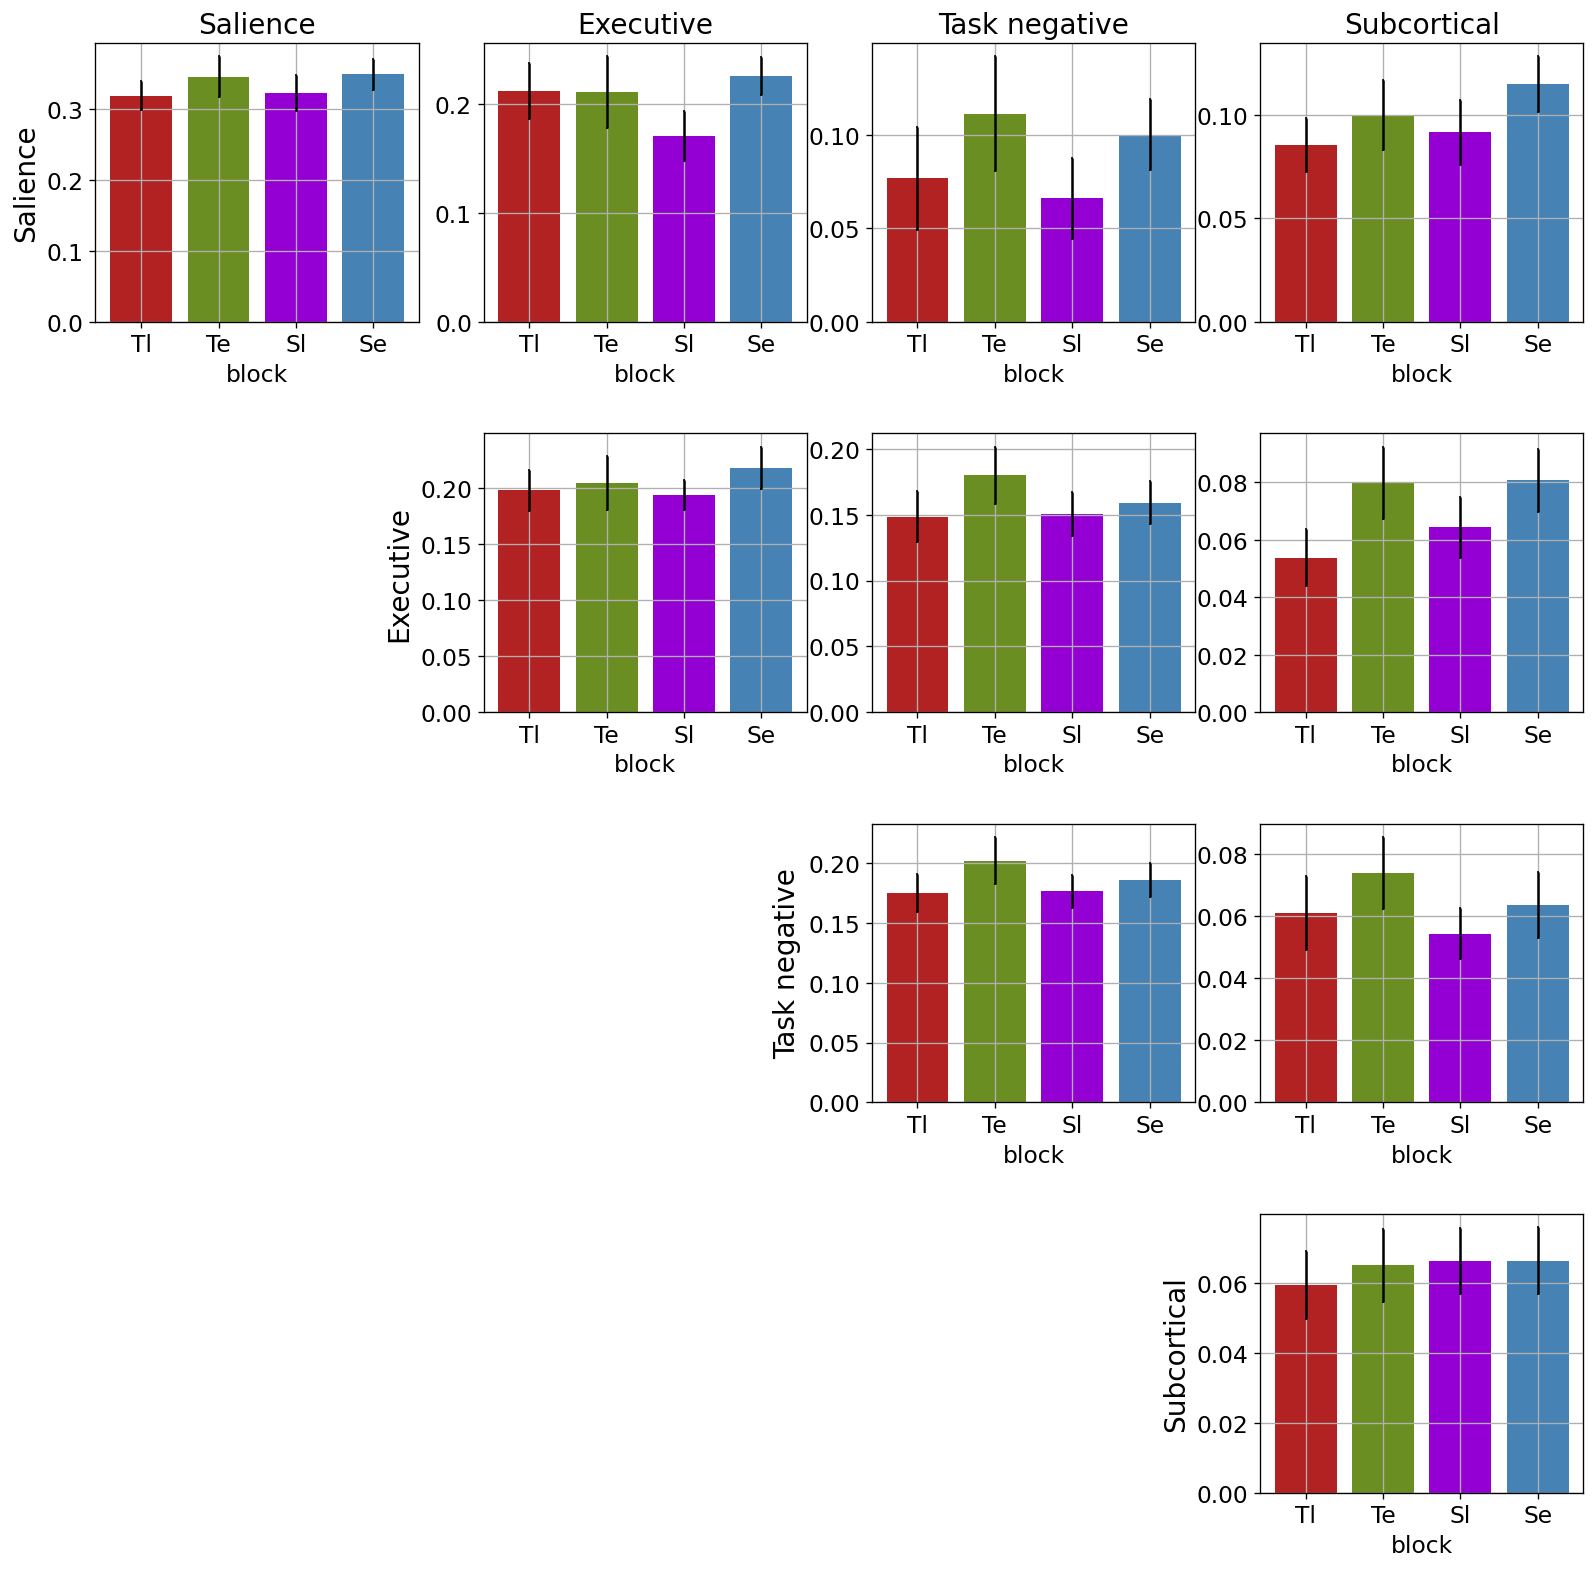

In [26]:
# within- and between-network positive weights
nw_weights_pos = isc_utils.get_nw_weights(
    args, 
    all_sq_fcs_pos
)

args.plot_colors = {
    'Threat_late':'firebrick', 'Threat_early':'olivedrab', 
    'Safe_late':'darkviolet',   'Safe_early':'steelblue'
}
isc_utils.plot_max_nw_weights(args, nw_weights_pos)

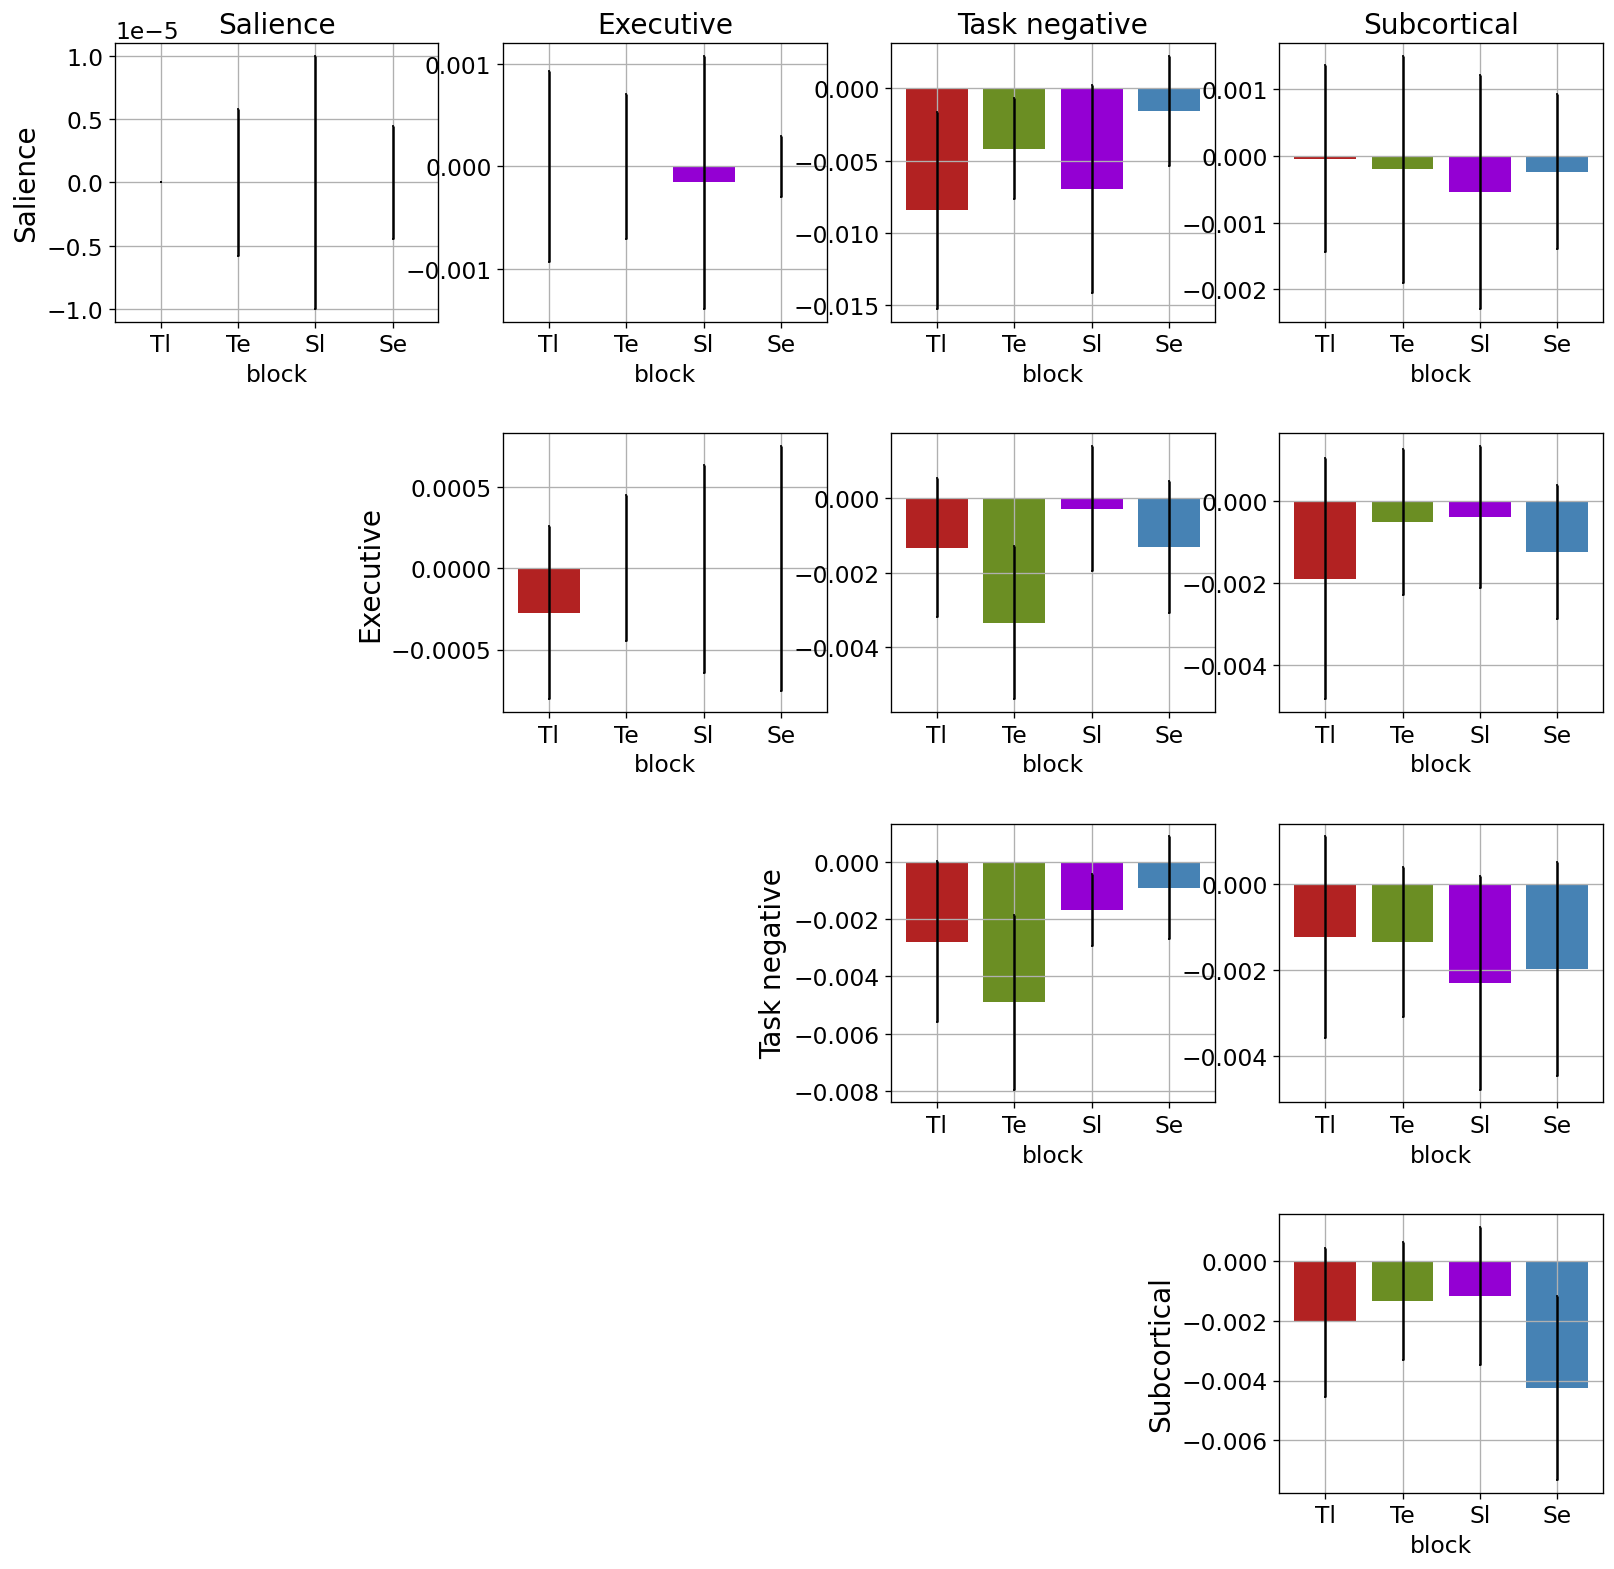

In [27]:
# within- and between-network negative weights
nw_weights_neg = isc_utils.get_nw_weights(
    args, 
    all_sq_fcs_neg
)

args.plot_colors = {
    'Threat_late':'firebrick', 'Threat_early':'olivedrab', 
    'Safe_late':'darkviolet',   'Safe_early':'steelblue'
}
isc_utils.plot_max_nw_weights(args, -1 * nw_weights_neg)

### basic network measures

In [28]:
nw_measures_pos = compute_network_measures(args, all_sq_fcs_pos.copy())
nw_measures_neg = compute_network_measures(args, all_sq_fcs_neg.copy())

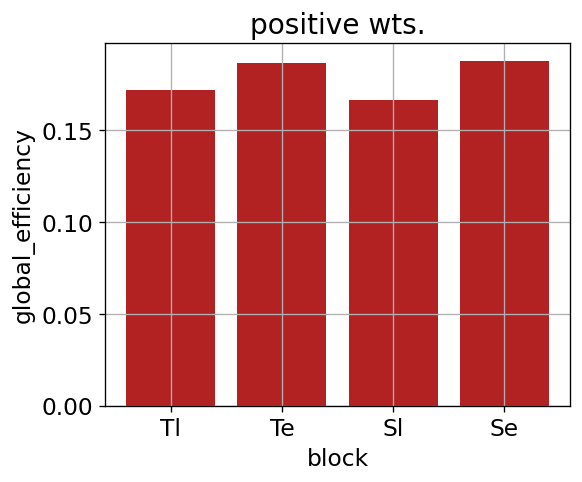

In [29]:
args.plot_colors = {'global_efficiency':'firebrick'}
args.title = f"positive wts."
plot_max_global_efficiency(args, nw_measures_pos)

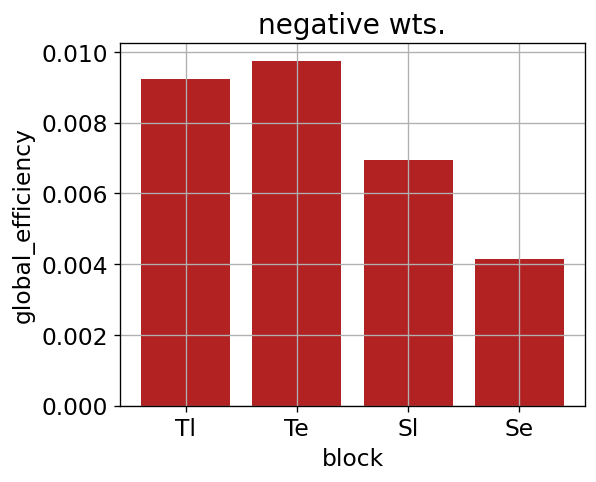

In [30]:
args.plot_colors = {'global_efficiency':'firebrick'}
args.title = f"negative wts."
plot_max_global_efficiency(args, nw_measures_neg)

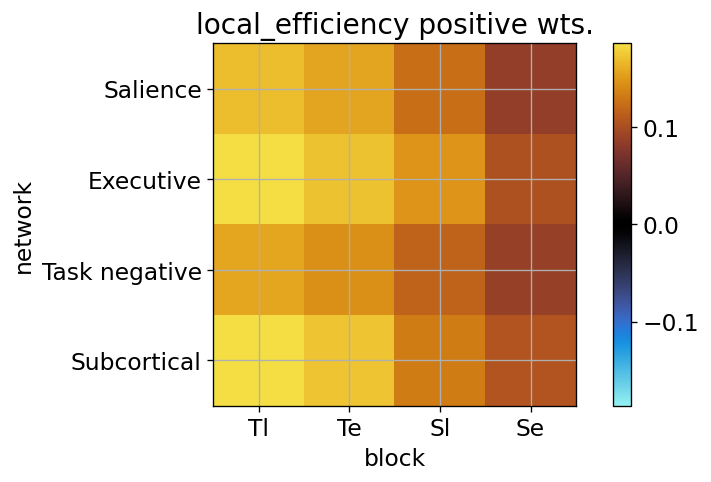

In [31]:
args.title = f"positive wts."
plot_max_local_efficiency(args, nw_measures_pos)

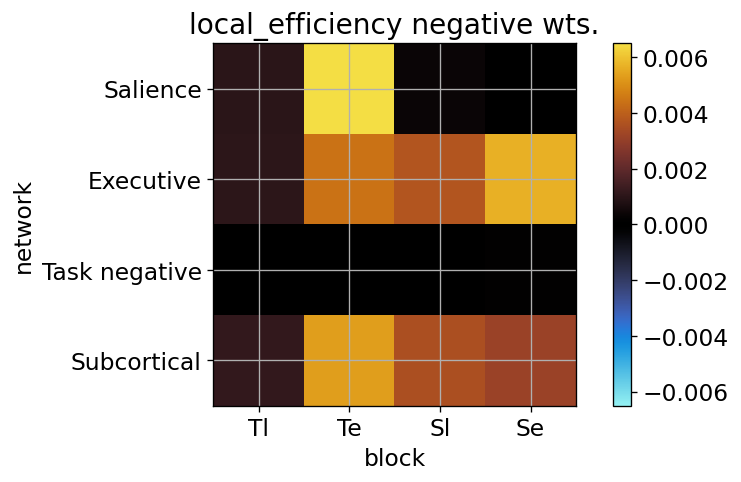

In [32]:
args.title = f"negative wts."
plot_max_local_efficiency(args, nw_measures_neg)

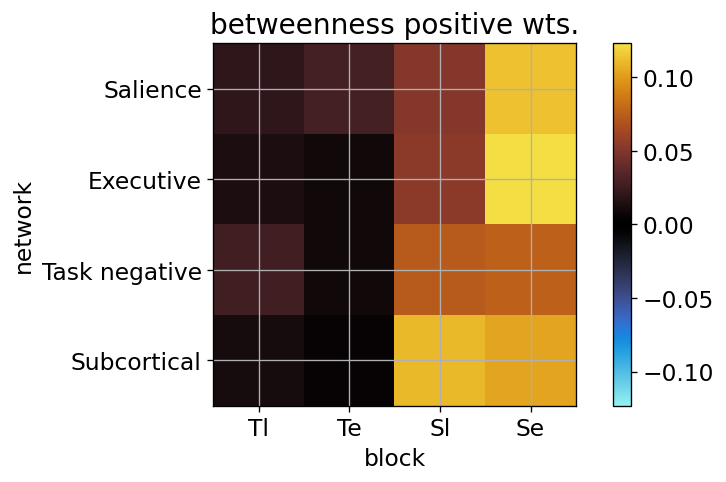

In [33]:
args.title = f"positive wts."
plot_max_betweenness(args, nw_measures_pos)

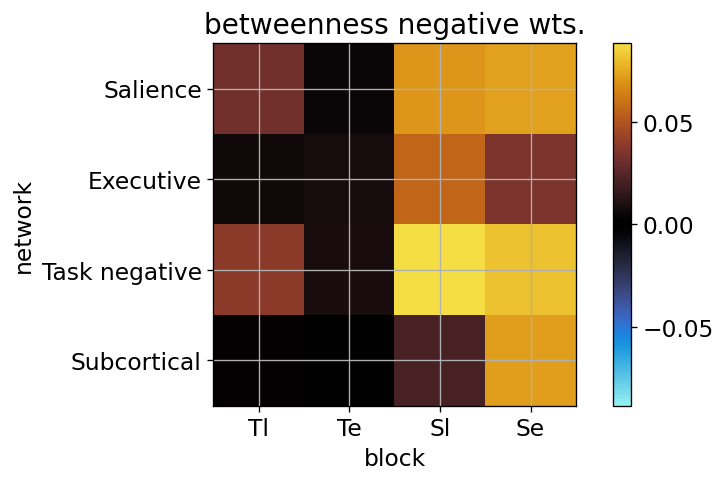

In [34]:
args.title = f"negative wts."
plot_max_betweenness(args, nw_measures_neg)

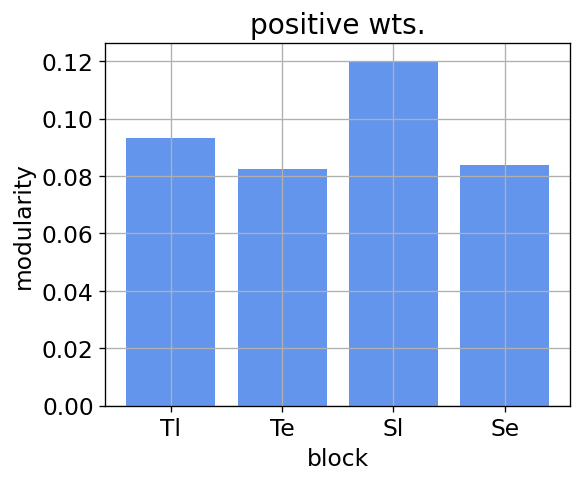

In [35]:
args.plot_colors = {
    'modularity': 'cornflowerblue'
}
args.title = f"positive wts."
plot_max_modularity(args, nw_measures_pos)

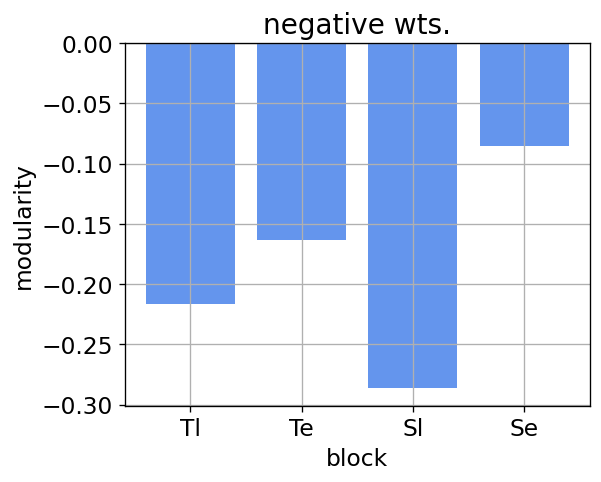

In [36]:
args.plot_colors = {
    'modularity': 'cornflowerblue'
}
args.title = f"negative wts."
plot_max_modularity(args, nw_measures_neg)